In [131]:
#import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import urllib.request
import requests
import seaborn as sns
import re
from PIL import Image
from io import BytesIO
import unicodedata
import plotly.express as px
import json
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression # Importando Logistic Regression
from google.colab import files




df_vagas = pd.read_json ("/content/vagas.json")

# --------------------------
# 1. Leitura e Flatten do JSON
# --------------------------
def carregar_vagas_json(filepath):
    """
    Carrega dados de um arquivo .json onde o ID da vaga é a chave principal.

    Retorna um DataFrame com os dados flatten e o ID da vaga como índice.
    """

    # Abrir e carregar JSON
    with open(filepath, "r", encoding="utf-8") as f:
        json_data = json.load(f)

    registros = []

    for id_vaga, conteudo in json_data.items():
        registro = {"id_vaga": id_vaga}
        for secao, campos in conteudo.items():
            if isinstance(campos, dict):
                for chave, valor in campos.items():
                    registro[f"{secao}_{chave}"] = valor
            else:
                registro[secao] = campos
        registros.append(registro)

    df = pd.DataFrame(registros)
    df.set_index("id_vaga", inplace=True)
    return df


In [132]:
df_vagas = carregar_vagas_json("vagas.json")
#df_vagas.set_index("id_vaga", inplace=True)

## Limpando o nome das coluna

In [133]:

def limpar_nomes_colunas(df):
    df_vagas.columns = df.columns.str.replace(r"^(informacoes_basicas_|perfil_vaga_|beneficios_)", "", regex=True)
    return df

df_vagas = limpar_nomes_colunas(df_vagas)


## Analisando valores em branco

In [134]:
em_branco = df_vagas.apply(lambda col: (col.astype(str).str.strip() == "").sum())
em_branco = em_branco[em_branco > 0].sort_values(ascending=False)

print("🔎 Colunas com campos EM BRANCO:")
display(em_branco)

🔎 Colunas com campos EM BRANCO:


,0
valor_compra_2,14034
horario_trabalho,13943
outro_idioma,13708
bairro,12990
regiao,12669
nome,9492
telefone,9316
equipamentos_necessarios,7150
viagens_requeridas,6998
origem_vaga,5143


## Limpeza dos dados

In [135]:
# 2. Limpeza e Conversões
# --------------------------
def tratar_dados(df_vagas):
    # Datas
    df_vagas["data_requicisao"] = pd.to_datetime(df_vagas["data_requicisao"], dayfirst=True, errors='coerce')
    df_vagas["limite_esperado_para_contratacao"] = pd.to_datetime(df_vagas["limite_esperado_para_contratacao"], dayfirst=True, errors='coerce')
    df_vagas["dias_para_contratacao"] = (df_vagas["limite_esperado_para_contratacao"] - df_vagas["data_requicisao"]).dt.days

    # Extrair valor numérico do campo de venda
    def extrair_valor(valor):
        match = re.search(r"(\d+)", str(valor))
        return int(match.group(1)) if match else None

    df_vagas["valor_venda_num"] = df_vagas["valor_venda"].apply(extrair_valor)
    return df_vagas

df_vagas = tratar_dados(df_vagas) # Applying the function to process the data

<ipython-input-135-8851018f4e03>:6: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [136]:
colunas_para_remover = [
    "superior_imediato",
    "telefone",
    "pais",
    "local_trabalho",
    "faixa_etaria",
    "demais_observacoes",
    "equipamentos_necessarios",
    "valor_venda",
    "valor_compra_1",
    "valor_compra_2",
    "data_inicial",
    "data_final",
    "habilidades_comportamentais_necessarias",
    "nome_substituto",
    "bairro",
    "regiao",
    "principais_atividades",
    "nome",
    "competencia_tecnicas_e_comportamentais",
    "horario_trabalho",
    "prioridade_vaga",
    "solicitante_cliente",
    "prazo_contratacao",
    "objetivo_vaga",
    "origem_vaga",
    "valor_venda_num",
    "limite_esperado_para_contratacao",
    "dias_para_contratacao",
    "outro_idioma",
    "viagens_requeridas"
]

# Remove as colunas, se existirem
df_vagas = df_vagas.drop(columns=[col for col in colunas_para_remover if col in df_vagas.columns])


In [137]:
em_branco = df_vagas.apply(lambda col: (col.astype(str).str.strip() == "").sum())
em_branco = em_branco[em_branco > 0].sort_values(ascending=False)

print("🔎 Colunas com campos EM BRANCO:")
display(em_branco)

🔎 Colunas com campos EM BRANCO:


,0
vaga_especifica_para_pcd,1948
nivel_espanhol,1304
tipo_contratacao,604
cidade,51
areas_atuacao,15
estado,11


In [138]:
# Substituir strings vazias e NaNs por "Não Informado"
df_vagas["tipo_contratacao"] = df_vagas["tipo_contratacao"].replace("", "Não Informado").fillna("Não Informado")
df_vagas["vaga_especifica_para_pcd"] = df_vagas["vaga_especifica_para_pcd"].replace("", "Não Informado").fillna("Não Informado")
df_vagas["areas_atuacao"] = df_vagas["areas_atuacao"].replace("", "Não Informado").fillna("Não Informado")
df_vagas["nivel_espanhol"] = df_vagas["nivel_espanhol"].replace("", "Não Informado").fillna("Não Informado")
df_vagas["estado"] = df_vagas["estado"].replace("", "Não Informado").fillna("Não Informado")
df_vagas["cidade"] = df_vagas["cidade"].replace("", "Não Informado").fillna("Não Informado")

## Analisando os campos e os valores contidos

In [139]:
# Contagem ordenada por frequência (decrescente)
contagem_ordenada = df_vagas["titulo_vaga"].value_counts()

#print(contagem_ordenada)
contagem_ordenada.head(10)

,count
titulo_vaga,
PROXXI JR,80
SAP SD,55
PROXXI,45
SAP MM,28
Desenvolvedor Java,28
SAP ABAP,26
Analista Sistemas,21
Scrum Master,21
PROXXI Junior,19


In [140]:

if "areas_atuacao" in df_vagas.columns:
    df_vagas["areas_atuacao"] = (
        df_vagas["areas_atuacao"]
        .str.replace(r"^TI\s*-\s*", "", regex=True)     # Remove "TI - " do início
        .str.replace(r"[-\s]*$", "", regex=True)        # Remove traços/s espaços do final
        .str.strip()                                    # Remove espaços extras
    )

if "titulo_vaga" in df_vagas.columns:
    df_vagas["titulo_vaga"] = (
        df_vagas["titulo_vaga"]
        #.str.replace(r"^TI\s*-\s*", "", regex=True)     # Remove "TI - " do início
        .str.replace(r"[-\s]*$", "", regex=True)        # Remove traços/s espaços do final
        .str.strip()                                    # Remove espaços extras
    )


In [141]:
# Padronizar valores de texto para minúsculo
for col in df_vagas.columns:
    if df_vagas[col].dtype == "object":
        df_vagas[col] = df_vagas[col].astype(str).str.lower()


# Padronizar todos os valores para minúsculo (caso ainda não feito)
df_vagas["titulo_vaga"] = df_vagas["titulo_vaga"].astype(str).str.lower().str.strip()

# Criar mapeamento de sinônimos ou equivalências
mapeamento_titulo = {
    "proxxi jr": "proxxi junior",
    "proxxi júnior": "proxxi junior",
    "proxxi jr.": "proxxi junior"
    # você pode adicionar mais variações aqui
}

# Aplicar a substituição
df_vagas["titulo_vaga"] = df_vagas["titulo_vaga"].replace(mapeamento_titulo)


In [142]:
df_vagas["titulo_vaga"] = (
    df_vagas["titulo_vaga"]
    .str.replace(r"\d+", "", regex=True)  # Remove todos os números
    .str.replace(r"\s*-\s*", " ", regex=True)  # Substitui traços por espaço
    .str.strip()  # Remove espaços extras
    )

    # Função auxiliar para remover acentos
def remover_acentos(texto):
    return unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('utf-8')

# Extrai níveis profissionais normalizados (sem acento)
    niveis_profissionais_raw = (
    df_vagas["nivel profissional"]
    .dropna()
    .astype(str)
    .str.strip()
    .unique()
    )

    niveis_profissionais_normalizados = [remover_acentos(nivel.lower()) for nivel in niveis_profissionais_raw]

    # Função para limpar os títulos
    def limpar_titulo_vaga(texto):
        if pd.isna(texto):
            return texto
        texto_normalizado = remover_acentos(texto.lower())

        for nivel in niveis_profissionais_normalizados:
            texto_normalizado = re.sub(rf"\b{re.escape(nivel)}\b", "", texto_normalizado, flags=re.IGNORECASE)

    # Remove espaços extras
            texto_limpo = re.sub(r"\s+", " ", texto_normalizado).strip()
            return texto_limpo

    # Aplica ao campo de título
    df_vagas["titulo_vaga"] = df_vagas["titulo_vaga"].apply(limpar_titulo_vaga)

In [143]:
df_vagas["titulo_vaga"] = df_vagas["titulo_vaga"].str.replace(
    r"\(?prospec\.?\s?jan\.?\)?", "", regex=True
).str.replace(r"\s{2,}", " ").str.strip()


In [144]:
# Lista de palavras a remover (com variantes)
palavras_remover = [
    r"\bsênior\b", r"\bsenior\b", r"\bsr\b", r"\bSR\b", r"\bSr\b",
    r"\bpleno\b", r"\bpl\b", r"\bPl\b",
    r"\bjúnior\b", r"\bjunior\b", r"\bjr\b", r"\bJR\b"
]

# Combina todas as palavras em uma expressão regex
padrao = "|".join(palavras_remover)

# Aplica a limpeza
df_vagas["titulo_vaga"] = (
    df_vagas["titulo_vaga"]
    .str.replace(padrao, "", regex=True)
    .str.replace(r"\s{2,}", " ", regex=True)  # remove múltiplos espaços
    .str.strip()
)


df_vagas["titulo_vaga"] = (
    df_vagas["titulo_vaga"]
    .str.replace(r"[-/\\()]", "", regex=True)   # Remove -, /, \, (, )
    .str.replace(r"\s{2,}", " ", regex=True)    # Remove múltiplos espaços
    .str.strip()
)



In [145]:
import re

def padronizar_titulo_vaga(texto):
    if pd.isna(texto):
        return texto
    texto = texto.lower().strip()

    # Remover palavras irrelevantes
    texto = re.sub(r'\b(consultora|sap funcional|funcional|consultoria)\b', '', texto)
    # Substituir símbolos
    texto = re.sub(r'[\+\-/]', ' ', texto)
    # Remover múltiplos espaços
    texto = re.sub(r'\s+', ' ', texto)
    # Manter apenas os termos relevantes (sap + módulo)
    if "sap" in texto:
        match = re.findall(r'sap\s*(\w+)', texto)
        if match:
            return "sap " + " ".join(match).strip()
        return "sap"
    return texto.strip()

# Aplicar no DataFrame
df_vagas["titulo_vaga"] = df_vagas["titulo_vaga"].apply(padronizar_titulo_vaga)


In [146]:
def padronizar_titulo_vaga2(texto):
        if pd.isna(texto):
            return texto

        texto = texto.strip().lower()

        # Lista de módulos SAP relevantes
        modulos = ["mm", "sd", "fi", "pp", "tm", "co", "abap", "basis", "fiori", "bw", "qa"]

        # Se o texto for exatamente um módulo SAP, substitui diretamente
        if texto in modulos:
            return f"sap {texto}"

        # Substitui abreviações ou combinações comuns (ex: sap funcional mm → consultor sap mm)
        for modulo in modulos:
            if f"sap funcional {modulo}" in texto:
                return f"sap {modulo}"
            elif texto == modulo:
                return f"sap {modulo}"

        return texto

df_vagas["titulo_vaga"] = df_vagas["titulo_vaga"].apply(padronizar_titulo_vaga2)


In [147]:
em_branco = df_vagas.apply(lambda col: (col.astype(str).str.strip() == "").sum())
em_branco = em_branco[em_branco > 0].sort_values(ascending=False)

print("🔎 Colunas com campos EM BRANCO:")
display(em_branco)

🔎 Colunas com campos EM BRANCO:


,0


In [148]:
# Get unique values as a NumPy array
unique_titles_array = df_vagas["titulo_vaga"].unique()

# Convert the NumPy array to a pandas Series to use .head()
unique_titles_series = pd.Series(unique_titles_array)

# Display the first few unique values
unique_titles_series.head(50).count()

np.int64(50)

In [149]:
# Contagem ordenada por frequência (decrescente)
contagem_ordenada = df_vagas["titulo_vaga"].value_counts()

#print(contagem_ordenada)
contagem_ordenada.tail(50)

,count
titulo_vaga,
engenheirodesenvolvedor de dados,1
cientista de dados eou engenheiro de machine learning,1
pmo project management office,1
. consultant blue yonder ams support,1
consultor abapcpi,1
adm governance sv,1
consultor ps,1
fiori sv,1
consultor bpc sac,1


In [150]:
# Filtrar vagas com a palavra "sap"
#vagas_sap = df_vagas[df_vagas["titulo_vaga"].str.contains("sap", na=False)]

# Selecionar apenas os campos desejados
#colunas_sap = ["vaga_sap", "titulo_vaga", "data_requicisao"]
#resultado_sap = vagas_sap[colunas_sap]

In [151]:
#contagem_sap = resultado_sap.count()
#print(f"A quantidade de linhas que tem a palavra sap no 'titulo_vaga': {contagem_sap}")

## Carregando dados do arquivo prospects.json

In [152]:
def carregar_prospects_json(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        json_data = json.load(f)

    registros = []

    for id_vaga, conteudo in json_data.items():
        titulo = conteudo.get("titulo", "")
        modalidade = conteudo.get("modalidade", "")
        prospects = conteudo.get("prospects", [])

        for p in prospects:
            registro = {
                "id_vaga": id_vaga,
                "titulo": titulo,
                "modalidade": modalidade,
            }
            registro.update(p)  # adiciona os campos do prospect
            registros.append(registro)

    df = pd.DataFrame(registros)
    df.set_index("id_vaga", inplace=True)
    return df

# Exemplo de uso:
df_prospects = carregar_prospects_json("prospects.json")


## Identificamos valores nulos

In [153]:
valores_nulos = df_prospects.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

print("🔎 Colunas com valores NULOS:")
display(valores_nulos)

🔎 Colunas com valores NULOS:


,0


In [154]:
colunas_para_remover_prospects = [
    "modalidade",
    "comentario",
    "ultima_atualizacao"
]

# Remove as colunas, se existirem
df_prospects = df_prospects.drop(columns=[col for col in colunas_para_remover_prospects if col in df_prospects.columns])


In [155]:
# Resetar índices
df_vagas_reset = df_vagas.reset_index()
df_prospects_reset = df_prospects.reset_index()

# Realizar o merge
df_vagas_prospects = pd.merge(df_prospects_reset, df_vagas_reset, how="left", on="id_vaga")

# Visualizar os dados combinados
print(f"🔗 Total de registros combinados: {len(df_vagas_prospects)}")
display(df_vagas_prospects.head())

🔗 Total de registros combinados: 53759


,id_vaga,titulo,nome,codigo,situacao_candidado,data_candidatura,recrutador,data_requicisao,titulo_vaga,vaga_sap,cliente,empresa_divisao,requisitante,analista_responsavel,tipo_contratacao,estado,cidade,vaga_especifica_para_pcd,nivel profissional,nivel_academico,nivel_ingles,nivel_espanhol,areas_atuacao
0,4530,CONSULTOR CONTROL M,José Vieira,25632,Encaminhado ao Requisitante,25-03-2021,Ana Lívia Moreira,2021-03-10,consultor control m,não,"morris, moran and dodson",decision são paulo,maria laura nogueira,ana lívia moreira,pj/autônomo,rio de janeiro,rio de janeiro,não,pleno,ensino superior completo,nenhum,nenhum,desenvolvimento/programação
1,4530,CONSULTOR CONTROL M,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,22-03-2021,Ana Lívia Moreira,2021-03-10,consultor control m,não,"morris, moran and dodson",decision são paulo,maria laura nogueira,ana lívia moreira,pj/autônomo,rio de janeiro,rio de janeiro,não,pleno,ensino superior completo,nenhum,nenhum,desenvolvimento/programação
2,4531,2021-2607395-PeopleSoft Application Engine-Dom...,Sra. Yasmin Fernandes,25364,Contratado pela Decision,17-03-2021,Juliana Cassiano,2021-03-10,peoplesoft application engine domain consultant,não,gonzalez and sons,decision são paulo,vitória melo,srta. bella ferreira,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,nenhum,nenhum,gestão e alocação de recursos de ti
3,4531,2021-2607395-PeopleSoft Application Engine-Dom...,Alexia Barbosa,25360,Encaminhado ao Requisitante,17-03-2021,Juliana Cassiano,2021-03-10,peoplesoft application engine domain consultant,não,gonzalez and sons,decision são paulo,vitória melo,srta. bella ferreira,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,nenhum,nenhum,gestão e alocação de recursos de ti
4,4533,2021-2605708-Microfocus Application Life Cycle...,Arthur Almeida,26338,Contratado pela Decision,29-04-2021,Stella Vieira,2021-03-11,microfocus application life cycle management h...,não,barnes-woods,decision são paulo,vitória melo,eloah leão,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,técnico,fluente,gestão e alocação de recursos de ti


In [156]:
valores_nulos = df_vagas_prospects.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

print("🔎 Colunas com valores NULOS:")
display(valores_nulos)

🔎 Colunas com valores NULOS:


,0
data_requicisao,24
titulo_vaga,24
vaga_sap,24
cliente,24
empresa_divisao,24
requisitante,24
analista_responsavel,24
tipo_contratacao,24
estado,24
cidade,24


## Existem 24 vagas que estão nodf_prospects e não estão no df_vagas id_vaga 280 e 11240

In [157]:
df_vagas_prospects = df_vagas_prospects.dropna(subset=["titulo_vaga"])

In [158]:
titulos_nulos = df_vagas_prospects[df_vagas_prospects["titulo_vaga"].isnull() | (df_vagas_prospects["titulo_vaga"].astype(str).str.strip() == "")]

titulos_nulos.head(24)

,id_vaga,titulo,nome,codigo,situacao_candidado,data_candidatura,recrutador,data_requicisao,titulo_vaga,vaga_sap,cliente,empresa_divisao,requisitante,analista_responsavel,tipo_contratacao,estado,cidade,vaga_especifica_para_pcd,nivel profissional,nivel_academico,nivel_ingles,nivel_espanhol,areas_atuacao


In [159]:
# Se estiver com índice, reseta e trata tipo
#df_completo = df_completo.reset_index()

df_vagas_prospects["id_vaga"] = df_vagas_prospects["id_vaga"].astype(int)

# Opcional: definir de novo como índice
#df_completo.set_index("id_vaga", inplace=True)

<ipython-input-159-ae815ce33877>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
df_vagas_prospects.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53735 entries, 0 to 53758
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_vaga                   53735 non-null  int64         
 1   titulo                    53735 non-null  object        
 2   nome                      53735 non-null  object        
 3   codigo                    53735 non-null  object        
 4   situacao_candidado        53735 non-null  object        
 5   data_candidatura          53735 non-null  object        
 6   recrutador                53735 non-null  object        
 7   data_requicisao           53735 non-null  datetime64[ns]
 8   titulo_vaga               53735 non-null  object        
 9   vaga_sap                  53735 non-null  object        
 10  cliente                   53735 non-null  object        
 11  empresa_divisao           53735 non-null  object        
 12  requisitante           

## Carregando o arquivo applicants.json

In [161]:
def carregar_applicants_json(filepath):
    with open(filepath, "r", encoding="utf-8") as f:
        json_data = json.load(f)

    registros = []

    for id_aplicante, conteudo in json_data.items():
        registro = {"id_aplicante": int(id_aplicante)}  # Convertendo ID para inteiro

        for secao, dados in conteudo.items():
            if isinstance(dados, dict):
                for chave, valor in dados.items():
                    registro[f"{secao}_{chave}"] = valor
            else:
                registro[secao] = dados  # Para campos como 'cv_pt' e 'cv_en'

        registros.append(registro)

    df = pd.DataFrame(registros)
    df.set_index("id_aplicante", inplace=True)
    return df

# Exemplo de uso:
# df_applicants = carregar_applicants_json("applicants - Copia.json")

In [162]:
df_applicants = carregar_applicants_json("applicants.json")
df_applicants.head()


,infos_basicas_telefone_recado,infos_basicas_telefone,infos_basicas_objetivo_profissional,infos_basicas_data_criacao,infos_basicas_inserido_por,infos_basicas_email,infos_basicas_local,infos_basicas_sabendo_de_nos_por,infos_basicas_data_atualizacao,infos_basicas_codigo_profissional,infos_basicas_nome,informacoes_pessoais_data_aceite,informacoes_pessoais_nome,informacoes_pessoais_cpf,informacoes_pessoais_fonte_indicacao,informacoes_pessoais_email,informacoes_pessoais_email_secundario,informacoes_pessoais_data_nascimento,informacoes_pessoais_telefone_celular,informacoes_pessoais_telefone_recado,informacoes_pessoais_sexo,informacoes_pessoais_estado_civil,informacoes_pessoais_pcd,informacoes_pessoais_endereco,informacoes_pessoais_skype,informacoes_pessoais_url_linkedin,informacoes_pessoais_facebook,informacoes_profissionais_titulo_profissional,informacoes_profissionais_area_atuacao,informacoes_profissionais_conhecimentos_tecnicos,informacoes_profissionais_certificacoes,informacoes_profissionais_outras_certificacoes,informacoes_profissionais_remuneracao,informacoes_profissionais_nivel_profissional,formacao_e_idiomas_nivel_academico,formacao_e_idiomas_nivel_ingles,formacao_e_idiomas_nivel_espanhol,formacao_e_idiomas_outro_idioma,cv_pt,cv_en,formacao_e_idiomas_instituicao_ensino_superior,formacao_e_idiomas_cursos,formacao_e_idiomas_ano_conclusao,informacoes_pessoais_download_cv,informacoes_profissionais_qualificacoes,informacoes_profissionais_experiencias,formacao_e_idiomas_outro_curso,cargo_atual_id_ibrati,cargo_atual_email_corporativo,cargo_atual_cargo_atual,cargo_atual_projeto_atual,cargo_atual_cliente,cargo_atual_unidade,cargo_atual_data_admissao,cargo_atual_data_ultima_promocao,cargo_atual_nome_superior_imediato,cargo_atual_email_superior_imediato
id_aplicante,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
31000,,(11) 97048-2708,,10-11-2021 07:29:49,Luna Correia,carolina_aparecida@gmail.com,,,10-11-2021 07:29:49,31000,Carolina Aparecida,Cadastro anterior ao registro de aceite,Carolina Aparecida,,:,carolina_aparecida@gmail.com,,0000-00-00,(11) 97048-2708,,,,,,,,,,,,,,,,,,,-,assistente administrativo\n\n\nsantosbatista\n...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31001,,(11) 93723-4396,Analista Administrativo,10-11-2021 08:56:16,Laura Pacheco,eduardo_rios@hotmail.com,"São Paulo, São Paulo",Outros,11-11-2021 11:10:31,31001,Eduardo Rios,Cadastro anterior ao registro de aceite,Eduardo Rios,,Outros: Contato do RH,eduardo_rios@hotmail.com,,28-12-1994,(11) 93723-4396,,Feminino,Solteiro,Não,são paulo,,,,Analista Administrativo,Administrativa,,,,1900,,Ensino Superior Incompleto,Nenhum,Nenhum,-,formação acadêmica\nensino médio (2º grau) em ...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31002,,(11) 92399-9824,Administrativo | Financeiro,10-11-2021 09:01:00,Laura Pacheco,pedro_henrique_carvalho@gmail.com,"São Paulo, São Paulo",Anúncio,10-11-2021 11:42:36,31002,Pedro Henrique Carvalho,Cadastro anterior ao registro de aceite,Pedro Henrique Carvalho,,Anúncio:,pedro_henrique_carvalho@gmail.com,,12-12-1988,(11) 92399-9824,,Feminino,Solteiro,Não,são paulo,,,,Administrativo | Financeiro,Administrativa,,"MS [77-418] MOS: Microsoft Office Word 2013, M...",,"2.500,00",,Ensino Superior Completo,Intermediário,Básico,Português - Fluente,objetivo: área administrativa | financeira\n\n...,,,Administração de Empresas,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31003,,(11) 98100-1727,Área administrativa,10-11-2021 09:08:13,Laura Pacheco,thiago_barbosa@hotmail.com,"São Paulo, São Paulo",Site de Empregos,10-11-2021 16:04:51,31003,Thiago Barbosa,Cadastro anterior ao registro de aceite,Thiago Barbosa,,Site de Empregos: Infojobs,thiago_barbosa@hotmail.com,,08-05-1992,(11) 98100-1727,,Feminino,Casado,Não,são paulo,,,,Área administrativa,Administrativa,,,,"1100,00",,Ensino Superior Incompleto,Nenhum,Nenhum,-,formação\nensino médio completo\ninformática i...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [163]:
df_applicants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42482 entries, 31000 to 5999
Data columns (total 57 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   infos_basicas_telefone_recado                     42482 non-null  object
 1   infos_basicas_telefone                            42482 non-null  object
 2   infos_basicas_objetivo_profissional               42482 non-null  object
 3   infos_basicas_data_criacao                        42482 non-null  object
 4   infos_basicas_inserido_por                        42482 non-null  object
 5   infos_basicas_email                               42482 non-null  object
 6   infos_basicas_local                               42482 non-null  object
 7   infos_basicas_sabendo_de_nos_por                  42482 non-null  object
 8   infos_basicas_data_atualizacao                    42482 non-null  object
 9   infos_basicas_codigo_profissio

In [164]:
colunas_para_remover = [
"infos_basicas_telefone_recado",
"infos_basicas_telefone",
"infos_basicas_objetivo_profissional",
"infos_basicas_data_criacao",
"infos_basicas_inserido_por",
"infos_basicas_email",
"infos_basicas_local",
"infos_basicas_sabendo_de_nos_por",
"infos_basicas_data_atualizacao",
"informacoes_pessoais_data_aceite",
"informacoes_pessoais_cpf",
"informacoes_pessoais_fonte_indicacao",
"informacoes_pessoais_email_secundario",
"informacoes_pessoais_data_nascimento",
"informacoes_pessoais_telefone_recado",
"informacoes_pessoais_sexo",
"informacoes_pessoais_estado_civil",
"informacoes_pessoais_pcd",
"informacoes_pessoais_endereco",
"informacoes_pessoais_skype",
"informacoes_pessoais_url_linkedin",
"informacoes_pessoais_facebook",
"informacoes_profissionais_remuneracao",
"formacao_e_idiomas_nivel_academico",
"cv_en",
"formacao_e_idiomas_instituicao_ensino_superior",
"formacao_e_idiomas_cursos",
"formacao_e_idiomas_ano_conclusao",
"informacoes_profissionais_qualificacoes",
"informacoes_profissionais_experiencias",
"formacao_e_idiomas_outro_curso",
"cargo_atual_id_ibrati",
"cargo_atual_email_corporativo",
"cargo_atual_projeto_atual",
"cargo_atual_cliente",
"cargo_atual_unidade",
"cargo_atual_data_ultima_promocao",
"cargo_atual_nome_superior_imediato",
"cargo_atual_email_superior_imediato",
"informacoes_pessoais_download_cv",
"cargo_atual_cargo_atual",
"cargo_atual_data_admissao",
"infos_basicas_codigo_profissional",
"infos_basicas_nome",
"informacoes_profissionais_outras_certificacoes" ,
"informacoes_profissionais_conhecimentos_tecnicos",
"formacao_e_idiomas_outro_idioma"
]

# Remove as colunas, se existirem
df_applicants = df_applicants.drop(columns=[col for col in colunas_para_remover if col in df_applicants.columns])


In [165]:
def limpar_nomes_colunas(df):
    df_applicants.columns = df.columns.str.replace(r"^(infos_basicas_|informacoes_pessoais_|informacoes_profissionais_|formacao_e_idiomas_|cargo_atual_)", "", regex=True)
    return df

df_applicants = limpar_nomes_colunas(df_applicants)

In [166]:
df_applicants.head(6)

,nome,email,telefone_celular,titulo_profissional,area_atuacao,certificacoes,nivel_profissional,nivel_ingles,nivel_espanhol,cv_pt
id_aplicante,,,,,,,,,,
31000,Carolina Aparecida,carolina_aparecida@gmail.com,(11) 97048-2708,,,,,,,assistente administrativo\n\n\nsantosbatista\n...
31001,Eduardo Rios,eduardo_rios@hotmail.com,(11) 93723-4396,Analista Administrativo,Administrativa,,,Nenhum,Nenhum,formação acadêmica\nensino médio (2º grau) em ...
31002,Pedro Henrique Carvalho,pedro_henrique_carvalho@gmail.com,(11) 92399-9824,Administrativo | Financeiro,Administrativa,"MS [77-418] MOS: Microsoft Office Word 2013, M...",,Intermediário,Básico,objetivo: área administrativa | financeira\n\n...
31003,Thiago Barbosa,thiago_barbosa@hotmail.com,(11) 98100-1727,Área administrativa,Administrativa,,,Nenhum,Nenhum,formação\nensino médio completo\ninformática i...
31004,Diogo das Neves,diogo_das_neves@hotmail.com,(11) 92517-2678,,,,,,,última atualização em 09/11/2021\n­ sp\n\nensi...
31005,Maya Fonseca,maya_fonseca@gmail.com,(11) 94989-4617,Administrativa/logística e ou comercial,Comercial,,,Básico,Básico,"brasileira\n41 anos, casada\nobjetivo: adminis..."


In [167]:
valores_nulos = df_applicants.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

print("🔎 Colunas com valores NULOS:")
display(valores_nulos)

🔎 Colunas com valores NULOS:


,0


## Pesquisando os valores em branco do df_applicants.

In [168]:
em_branco = df_applicants.apply(lambda col: (col.astype(str).str.strip() == "").sum())
em_branco = em_branco[em_branco > 0].sort_values(ascending=False)

print("Colunas com campos EM BRANCO:")
display(em_branco)

Colunas com campos EM BRANCO:


,0
nivel_profissional,42402
certificacoes,41954
nivel_espanhol,35795
area_atuacao,35731
nivel_ingles,35638
titulo_profissional,14416
cv_pt,13453
telefone_celular,1456


In [169]:
colunas_para_remover = [
"certificacoes",
"nivel_espanhol",
"area_atuacao",
"telefone_celular",
"cv_pt"
]

# Remove as colunas, se existirem
df_applicants = df_applicants.drop(columns=[col for col in colunas_para_remover if col in df_applicants.columns])


In [170]:
df_applicants.count()

,0
nome,42482
email,42482
titulo_profissional,42482
nivel_profissional,42482
nivel_ingles,42482


## Juntando os 3 arquivos em um unico DataFrame

In [171]:
# Garante que o índice está corretamente formatado
df_applicants = df_applicants.reset_index()

# Convert 'codigo' column in df_completo to int64 to match df_applicants['id_aplicante']
df_vagas_prospects['codigo'] = pd.to_numeric(df_vagas_prospects['codigo'], errors='coerce')

# Convert to int64 after handling potential NaNs
df_vagas_prospects['codigo'] = df_vagas_prospects['codigo'].astype('int64')


# Faz o merge entre os dataframes usando o campo 'codigo' e o índice de applicants
df_completo = pd.merge(
    df_vagas_prospects,
    df_applicants,
    how='left',
    left_on='codigo',
    right_on='id_aplicante'
)

In [172]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53735 entries, 0 to 53734
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_vaga                   53735 non-null  int64         
 1   titulo                    53735 non-null  object        
 2   nome_x                    53735 non-null  object        
 3   codigo                    53735 non-null  int64         
 4   situacao_candidado        53735 non-null  object        
 5   data_candidatura          53735 non-null  object        
 6   recrutador                53735 non-null  object        
 7   data_requicisao           53735 non-null  datetime64[ns]
 8   titulo_vaga               53735 non-null  object        
 9   vaga_sap                  53735 non-null  object        
 10  cliente                   53735 non-null  object        
 11  empresa_divisao           53735 non-null  object        
 12  requisitante      

In [173]:
df_completo.rename(columns={"nome_x": "nome_candidato"}, inplace=True)
df_completo.rename(columns={"nome_y": "nome_candidato2"}, inplace=True)
df_completo.rename(columns={"nivel_ingles_x": "nivel_ingles_vaga"}, inplace=True)
df_completo.rename(columns={"nivel_ingles_y": "nivel_ingles_candidato"}, inplace=True)


In [174]:
valores_nulos = df_completo.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

print("🔎 Colunas com valores NULOS:")
display(valores_nulos)

🔎 Colunas com valores NULOS:


,0
id_aplicante,8664
nome_candidato2,8664
email,8664
titulo_profissional,8664
nivel_profissional,8664
nivel_ingles_candidato,8664


In [175]:
titulos_nulos = df_completo[df_completo["id_aplicante"].isnull() | (df_completo["id_aplicante"].astype(str).str.strip() == "")]

titulos_nulos.head()

,id_vaga,titulo,nome_candidato,codigo,situacao_candidado,data_candidatura,recrutador,data_requicisao,titulo_vaga,vaga_sap,cliente,empresa_divisao,requisitante,analista_responsavel,tipo_contratacao,estado,cidade,vaga_especifica_para_pcd,nivel profissional,nivel_academico,nivel_ingles_vaga,nivel_espanhol,areas_atuacao,id_aplicante,nome_candidato2,email,titulo_profissional,nivel_profissional,nivel_ingles_candidato
22,4535,Microfocus QTP - UFT Automation Testing-Lead-2...,Lunna Alves,22977,Contratado pela Decision,27-04-2021,Yasmin da Rosa,2021-03-11,microfocus qtp uft automation testing lead,não,barnes-woods,decision são paulo,vitória melo,eloah leão,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,técnico,nenhum,gestão e alocação de recursos de ti,NaN,NaN,NaN,NaN,NaN,NaN
28,4537,PMO Practitioner - 11744940,Gustavo Henrique Cirino,22662,Prospect,12-03-2021,Dra. Luara Siqueira,2021-03-11,pmo practitioner,não,nelson-page,decision são paulo,cecília freitas,juliana cassiano,"pj/autônomo, clt full",minas gerais,nova lima,não,analista,ensino superior completo,básico,básico,projetos,NaN,NaN,NaN,NaN,NaN,NaN
29,4537,PMO Practitioner - 11744940,Vitor Hugo Garcia,22626,Encaminhado ao Requisitante,12-03-2021,Dra. Luara Siqueira,2021-03-11,pmo practitioner,não,nelson-page,decision são paulo,cecília freitas,juliana cassiano,"pj/autônomo, clt full",minas gerais,nova lima,não,analista,ensino superior completo,básico,básico,projetos,NaN,NaN,NaN,NaN,NaN,NaN
30,4537,PMO Practitioner - 11744940,Dr. Matteo Camargo,22608,Encaminhado ao Requisitante,12-03-2021,Dra. Luara Siqueira,2021-03-11,pmo practitioner,não,nelson-page,decision são paulo,cecília freitas,juliana cassiano,"pj/autônomo, clt full",minas gerais,nova lima,não,analista,ensino superior completo,básico,básico,projetos,NaN,NaN,NaN,NaN,NaN,NaN
31,4537,PMO Practitioner - 11744940,Ravi Lucca Pereira,22607,Encaminhado ao Requisitante,12-03-2021,Dra. Luara Siqueira,2021-03-11,pmo practitioner,não,nelson-page,decision são paulo,cecília freitas,juliana cassiano,"pj/autônomo, clt full",minas gerais,nova lima,não,analista,ensino superior completo,básico,básico,projetos,NaN,NaN,NaN,NaN,NaN,NaN


In [176]:
df_completo = df_completo[~df_completo["id_aplicante"].isnull() &
                             (df_completo["id_aplicante"].astype(str).str.strip() != "")]
df_completo.head()


,id_vaga,titulo,nome_candidato,codigo,situacao_candidado,data_candidatura,recrutador,data_requicisao,titulo_vaga,vaga_sap,cliente,empresa_divisao,requisitante,analista_responsavel,tipo_contratacao,estado,cidade,vaga_especifica_para_pcd,nivel profissional,nivel_academico,nivel_ingles_vaga,nivel_espanhol,areas_atuacao,id_aplicante,nome_candidato2,email,titulo_profissional,nivel_profissional,nivel_ingles_candidato
0,4530,CONSULTOR CONTROL M,José Vieira,25632,Encaminhado ao Requisitante,25-03-2021,Ana Lívia Moreira,2021-03-10,consultor control m,não,"morris, moran and dodson",decision são paulo,maria laura nogueira,ana lívia moreira,pj/autônomo,rio de janeiro,rio de janeiro,não,pleno,ensino superior completo,nenhum,nenhum,desenvolvimento/programação,25632.0,José Vieira,josé_vieira@gmail.com,,,
1,4530,CONSULTOR CONTROL M,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,22-03-2021,Ana Lívia Moreira,2021-03-10,consultor control m,não,"morris, moran and dodson",decision são paulo,maria laura nogueira,ana lívia moreira,pj/autônomo,rio de janeiro,rio de janeiro,não,pleno,ensino superior completo,nenhum,nenhum,desenvolvimento/programação,25529.0,Srta. Isabela Cavalcante,srta._isabela_cavalcante@hotmail.com,ANALISTA DE REDES E TELEPROCESSAMENTO/INFRAEST...,,Intermediário
2,4531,2021-2607395-PeopleSoft Application Engine-Dom...,Sra. Yasmin Fernandes,25364,Contratado pela Decision,17-03-2021,Juliana Cassiano,2021-03-10,peoplesoft application engine domain consultant,não,gonzalez and sons,decision são paulo,vitória melo,srta. bella ferreira,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,nenhum,nenhum,gestão e alocação de recursos de ti,25364.0,Sra. Yasmin Fernandes,sra._yasmin_fernandes@hotmail.com,Liderança / Desenvolvimento,,Avançado
3,4531,2021-2607395-PeopleSoft Application Engine-Dom...,Alexia Barbosa,25360,Encaminhado ao Requisitante,17-03-2021,Juliana Cassiano,2021-03-10,peoplesoft application engine domain consultant,não,gonzalez and sons,decision são paulo,vitória melo,srta. bella ferreira,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,nenhum,nenhum,gestão e alocação de recursos de ti,25360.0,Alexia Barbosa,alexia_barbosa@hotmail.com,,,
4,4533,2021-2605708-Microfocus Application Life Cycle...,Arthur Almeida,26338,Contratado pela Decision,29-04-2021,Stella Vieira,2021-03-11,microfocus application life cycle management h...,não,barnes-woods,decision são paulo,vitória melo,eloah leão,pj/autônomo,são paulo,são paulo,não,sênior,ensino médio completo,técnico,fluente,gestão e alocação de recursos de ti,26338.0,Arthur Almeida,arthur_almeida@gmail.com,,,


In [177]:
df_completo["situacao_candidado"].dropna().unique()

array(['Encaminhado ao Requisitante', 'Contratado pela Decision',
       'Desistiu', 'Documentação PJ', 'Não Aprovado pelo Cliente',
       'Prospect', 'Não Aprovado pelo RH', 'Aprovado',
       'Não Aprovado pelo Requisitante', 'Inscrito', 'Entrevista Técnica',
       'Em avaliação pelo RH', 'Contratado como Hunting',
       'Desistiu da Contratação', 'Entrevista com Cliente',
       'Documentação CLT', 'Recusado', 'Documentação Cooperado',
       'Sem interesse nesta vaga', 'Encaminhar Proposta',
       'Proposta Aceita'], dtype=object)

In [178]:
# Listas de situações
aderente_valores = [
    'Contratado pela Decision',
    'Documentação PJ',
    'Aprovado',
    'Contratado como Hunting',
    'Documentação CLT',
    'Documentação Cooperado',
    'Encaminhar Proposta',
    'Proposta Aceita'
]

nao_aderente_valores = [
    'Encaminhado ao Requisitante',
    'Desistiu',
    'Não Aprovado pelo Cliente',
    'Prospect',
    'Não Aprovado pelo RH',
    'Não Aprovado pelo Requisitante',
    'Inscrito',
    'Entrevista Técnica',
    'Em avaliação pelo RH',
    'Desistiu da Contratação',
    'Entrevista com Cliente',
    'Recusado',
    'Sem interesse nesta vaga'
]

# Criação da coluna "aderente"
df_completo["aderente"] = df_completo["situacao_candidado"].apply(
    lambda x: 1 if x in aderente_valores else (0 if x in nao_aderente_valores else None)
)


In [179]:
from google.colab import files

In [180]:
df_completo.to_csv("df_completo_exportado.csv", index=False, encoding="utf-8-sig")


## DASHBOARDS ##

In [181]:
df_completo_exportado = pd.read_csv ("/content/df_completo_exportado.csv")

In [182]:


# Garantir que a coluna esteja em formato datetime
df_completo_exportado["data_requicisao"] = pd.to_datetime(df_completo_exportado["data_requicisao"], errors='coerce')

# Calcular a data limite (últimos 12 meses)
data_limite = df_completo_exportado["data_requicisao"].max() - pd.DateOffset(months=12)

# Filtrar os dados dos últimos 12 meses
df_recent = df_completo_exportado[df_completo_exportado["data_requicisao"] >= data_limite]

# Agrupar por data
df_time_grouped = df_recent.groupby("data_requicisao").size().reset_index(name="quantidade")

# Gráfico de linha com Plotly
fig = px.line(
    df_time_grouped,
    x="data_requicisao",
    y="quantidade",
    markers=True,
    title="📅 Evolução de Vagas (Últimos 12 meses)",
    labels={"data_requicisao": "Data", "quantidade": "Qtd. Vagas"},
    template="plotly_white",
    color_discrete_sequence=["#1f77b4"]
)

fig.update_traces(
    hovertemplate="Data: %{x|%d-%m-%Y}<br>Qtd: %{y}",
    line=dict(width=3),
    marker=dict(size=6)
)
fig.update_layout(
    title_x=0.5,
    hovermode="x unified",
    margin=dict(t=50, b=40, l=40, r=40)
)

# Mostrar o gráfico
fig.show()


<ipython-input-183-a80bace40861>:32: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.



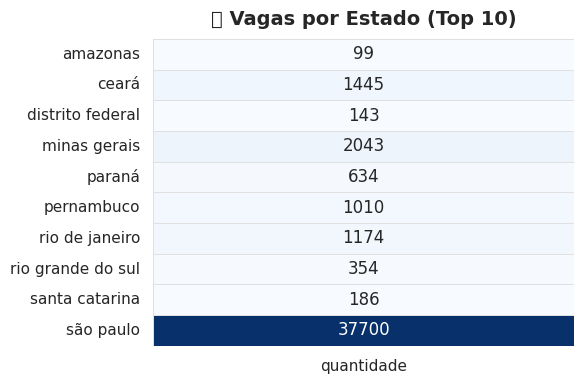

In [183]:
# Contar vagas por estado (Top 10)
vagas_estado = df_completo_exportado["estado"].value_counts().head(10).sort_values(ascending=True)

# Estrutura do heatmap
heat_data = pd.DataFrame(vagas_estado).reset_index()
heat_data.columns = ["estado", "quantidade"]
heat_matrix = heat_data.pivot_table(index="estado", values="quantidade").astype(int)

# Estilo visual do seaborn
sns.set(style="whitegrid")

# Criar o heatmap
fig4, ax4 = plt.subplots(figsize=(6, 4))
sns.heatmap(
    heat_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",               # Paleta moderna
    linewidths=0.5,
    linecolor="#e0e0e0",
    cbar=False,
    ax=ax4
)

# Estética
ax4.set_xlabel("")
ax4.set_ylabel("")
sns.despine(left=True, bottom=True)

# Exibir no Colab
plt.title("📍 Vagas por Estado (Top 10)", fontsize=14, weight='bold', pad=10)
plt.tight_layout()
plt.show()


<ipython-input-184-fc2d3408fb08>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




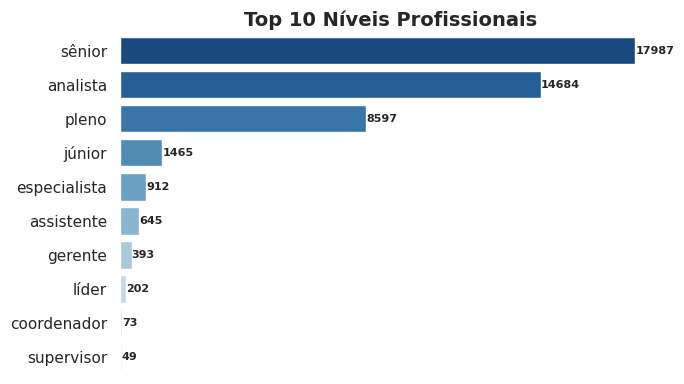

In [184]:
# Suponha que você já tenha o DataFrame df_filtrado
# Exemplo para contar os níveis profissionais
nivel_counts = df_completo_exportado["nivel profissional"].value_counts().head(10).sort_values(ascending=False)

# Criar o gráfico
fig_nv2, ax_nv2 = plt.subplots(figsize=(7, 4))
sns.barplot(y=nivel_counts.index, x=nivel_counts.values, ax=ax_nv2, palette="Blues_r")

# Adiciona rótulos nas barras
for i, v in enumerate(nivel_counts.values):
    ax_nv2.text(v + 0.3, i, str(v), va='center', fontsize=8, fontweight='bold')

# Estilização
ax_nv2.set_xlabel("")
ax_nv2.set_ylabel("")
ax_nv2.set_xticks([])
sns.despine(left=True, bottom=True)

# Título opcional
plt.title("Top 10 Níveis Profissionais", fontsize=14, fontweight='bold')

# Exibir no Colab
plt.tight_layout()
plt.show()


<ipython-input-185-ae97de9ed785>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




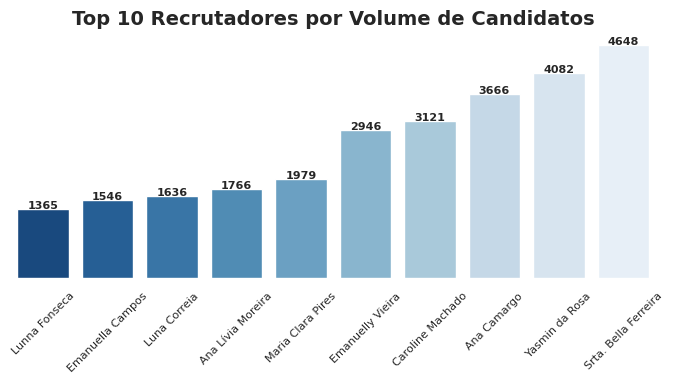

In [185]:
# Exemplo: suponha que `top_recrutadores` já foi definido assim:
# top_recrutadores = df["recrutador"].value_counts().head(10).sort_values(ascending=False)
top_recrutadores = df_completo_exportado["recrutador"].value_counts().head(10).sort_values(ascending=True)

fig4, ax4 = plt.subplots(figsize=(7, 4))
sns.barplot(x=top_recrutadores.index, y=top_recrutadores.values, ax=ax4, palette="Blues_r")

# Rótulos nas barras
for i, v in enumerate(top_recrutadores.values):
    ax4.text(i, v + 0.3, str(v), ha='center', fontsize=8, fontweight='bold')

# Estilo visual
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.set_yticks([])
ax4.tick_params(axis='x', labelsize=8)
plt.xticks(rotation=45) #, ha='right'
sns.despine(left=True, bottom=True)

# Título
plt.title("Top 10 Recrutadores por Volume de Candidatos", fontsize=14, fontweight='bold')

# Mostrar o gráfico no Colab
plt.tight_layout()
plt.show()


## Iniciando os testes para maepar candidatos aderentes

### Interpretando os resultados
Cada ponto é um candidato aderente.

A cor representa o cluster atribuído.

Se houver separação clara entre grupos, significa que os candidatos com características semelhantes estão agrupados.

Você pode analisar df_aderentes.groupby("cluster")[features].agg(...) para entender o perfil médio de cada grupo (por exemplo, Cluster 2 pode representar candidatos com perfil SAP Sênior, fluente em inglês, e preferência por CLT).

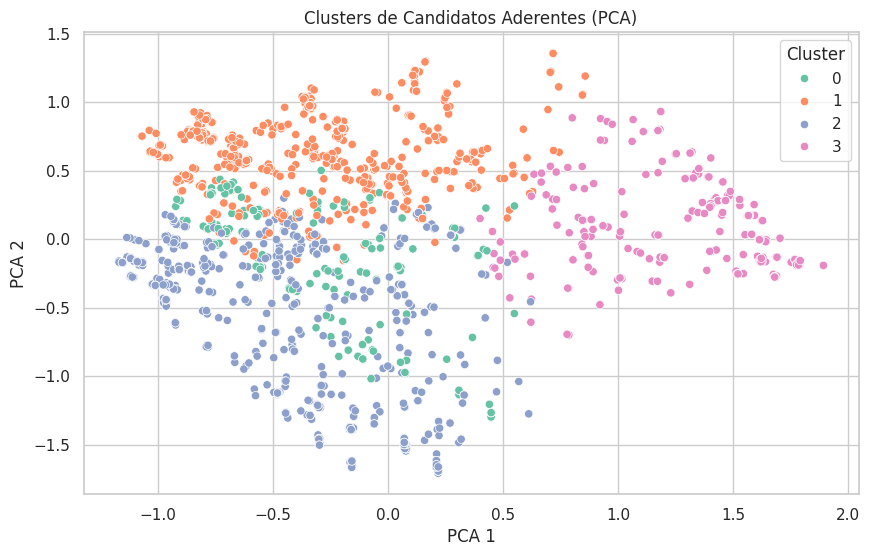

In [186]:

# 1. Carregar os dados
# df = pd.read_csv("seu_arquivo.csv")  # se necessário
df_aderentes = df_completo_exportado[df_completo_exportado["aderente"] == 1].copy()

# 2. Selecionar colunas relevantes
features = [
    "titulo_vaga", "titulo_profissional", "nivel profissional", "nivel_academico",
    "tipo_contratacao", "vaga_sap", "vaga_especifica_para_pcd",
    "cliente", "estado", "cidade"
]
df_modelo = df_aderentes[features].fillna("nao_informado")

# 3. One-hot encoding com ColumnTransformer
cat_cols = df_modelo.select_dtypes(include="object").columns.tolist()
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# 4. Pipeline KMeans
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("cluster", KMeans(n_clusters=4, random_state=42))
])

# 5. Treinar modelo
pipeline.fit(df_modelo)

# 6. Atribuir cluster ao DataFrame
df_aderentes["cluster"] = pipeline.named_steps["cluster"].labels_

# 7. Reduz dimensionalidade para visualização
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(pipeline.named_steps["preprocess"].transform(df_modelo))
df_aderentes["pca_1"] = X_reduced[:, 0]
df_aderentes["pca_2"] = X_reduced[:, 1]

# 8. Plotar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_aderentes, x="pca_1", y="pca_2", hue="cluster", palette="Set2")
plt.title("Clusters de Candidatos Aderentes (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [187]:
# Agrupar por cluster e aplicar contagem para entender os padrões mais comuns
resumo_clusters = df_aderentes.groupby("cluster")[features].agg(lambda x: x.value_counts().index[0])

# Exibir os perfis mais comuns por cluster
pd.set_option("display.max_columns", None)  # Mostrar todas as colunas
print(resumo_clusters)


                titulo_vaga     titulo_profissional nivel profissional  \
cluster                                                                  
0        desenvolvedor java                      TI              pleno   
1                  sap abap     Gerente de Projetos           analista   
2         analista sistemas     Gerente de Projetos             sênior   
3                    proxxi  Atendimento Backoffice             júnior   

                  nivel_academico tipo_contratacao vaga_sap  \
cluster                                                       
0         ensino técnico completo      pj/autônomo      não   
1        ensino superior completo         clt full      não   
2        ensino superior completo        cooperado      não   
3           ensino médio completo         clt full      não   

        vaga_especifica_para_pcd            cliente     estado       cidade  
cluster                                                                      
0                   

In [188]:
df_completo_exportado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45071 entries, 0 to 45070
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_vaga                   45071 non-null  int64         
 1   titulo                    45071 non-null  object        
 2   nome_candidato            45071 non-null  object        
 3   codigo                    45071 non-null  int64         
 4   situacao_candidado        45071 non-null  object        
 5   data_candidatura          45071 non-null  object        
 6   recrutador                45071 non-null  object        
 7   data_requicisao           45071 non-null  datetime64[ns]
 8   titulo_vaga               45071 non-null  object        
 9   vaga_sap                  45071 non-null  object        
 10  cliente                   45071 non-null  object        
 11  empresa_divisao           45071 non-null  object        
 12  requisitante      

In [189]:
valores_nulos = df_completo_exportado.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

print("🔎 Colunas com valores NULOS:")
display(valores_nulos)


🔎 Colunas com valores NULOS:


,0
nivel_profissional,44778
nivel_ingles_candidato,33667
titulo_profissional,20278


In [190]:
em_branco = df_completo_exportado.apply(lambda col: (col.astype(str).str.strip() == "").sum())
em_branco = em_branco[em_branco > 0].sort_values(ascending=False)

print("Colunas com campos EM BRANCO:")
display(em_branco)

Colunas com campos EM BRANCO:


,0


In [201]:
df_completo_exportado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45071 entries, 0 to 45070
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_vaga                   45071 non-null  int64         
 1   titulo                    45071 non-null  object        
 2   nome_candidato            45071 non-null  object        
 3   codigo                    45071 non-null  int64         
 4   situacao_candidado        45071 non-null  object        
 5   data_candidatura          45071 non-null  object        
 6   recrutador                45071 non-null  object        
 7   data_requicisao           45071 non-null  datetime64[ns]
 8   titulo_vaga               45071 non-null  object        
 9   vaga_sap                  45071 non-null  object        
 10  cliente                   45071 non-null  object        
 11  empresa_divisao           45071 non-null  object        
 12  requisitante      

In [191]:
#df_completo["nivel profissional"] = df_completo["nivel profissional"].replace("", None)
df_completo_exportado["nivel_profissional"] = df_completo_exportado["nivel_profissional"].fillna("Não Informado")

#df_completo["nivel_ingles"] = df_completo["nivel_ingles"].replace("", None)
df_completo_exportado["nivel_ingles_candidato"] = df_completo_exportado["nivel_ingles_candidato"].fillna("Não Informado")

#df_completo["titulo_profissional"] = df_completo["titulo_profissional"].replace("", None)
df_completo_exportado["titulo_profissional"] = df_completo_exportado["titulo_profissional"].fillna("Não Informado")

#df_completo["cv_pt"] = df_completo["cv_pt"].replace("", None)
#df_completo_exportado["cv_pt"] = df_completo_exportado["cv_pt"].fillna("Não Informado")

In [192]:
valores_nulos = df_completo_exportado.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0].sort_values(ascending=False)

print("🔎 Colunas com valores NULOS:")
display(valores_nulos)


🔎 Colunas com valores NULOS:


,0


In [193]:
df_completo_exportado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45071 entries, 0 to 45070
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_vaga                   45071 non-null  int64         
 1   titulo                    45071 non-null  object        
 2   nome_candidato            45071 non-null  object        
 3   codigo                    45071 non-null  int64         
 4   situacao_candidado        45071 non-null  object        
 5   data_candidatura          45071 non-null  object        
 6   recrutador                45071 non-null  object        
 7   data_requicisao           45071 non-null  datetime64[ns]
 8   titulo_vaga               45071 non-null  object        
 9   vaga_sap                  45071 non-null  object        
 10  cliente                   45071 non-null  object        
 11  empresa_divisao           45071 non-null  object        
 12  requisitante      

In [194]:
# Contagem ordenada por frequência (decrescente)
contagem_ordenada = df_completo_exportado["areas_atuacao"].value_counts()

#print(contagem_ordenada)
contagem_ordenada.head(50)

,count
areas_atuacao,
projetos,16899
sap,9766
gestão e alocação de recursos de ti,5274
desenvolvimento/programação,3811
administrativa,1843
sistemas e ferramentas,1290
financeira/controladoria,942
suporte,630
gestão e alocação de recursos de ti-ti - sap,607


### Teste 2 (removendo a coluna titulo_profissional e realizando o tratamento de valores nulos e em branco nas colunas ###

### Interpretando os resultados
Cada ponto é um candidato aderente.

A cor representa o cluster atribuído.

Se houver separação clara entre grupos, significa que os candidatos com características semelhantes estão agrupados.

Você pode analisar df_aderentes.groupby("cluster")[features].agg(...) para entender o perfil médio de cada grupo (por exemplo, Cluster 2 pode representar candidatos com perfil SAP Sênior, fluente em inglês, e preferência por CLT).

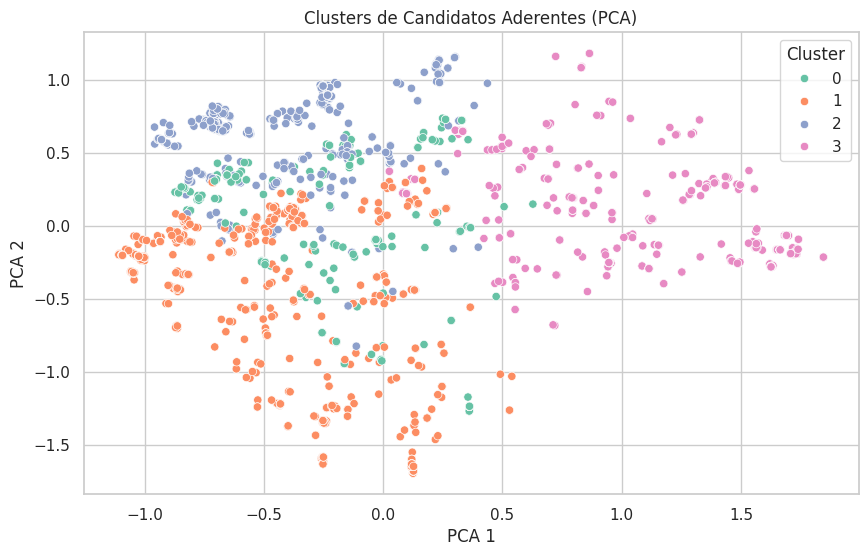

In [195]:

# 1. Carregar os dados
# df = pd.read_csv("seu_arquivo.csv")  # se necessário
df_aderentes = df_completo_exportado[df_completo_exportado["aderente"] == 1].copy()

# 2. Selecionar colunas relevantes
features = [
    "titulo_vaga", "nivel profissional", "nivel_academico",
    "tipo_contratacao", "vaga_sap", "vaga_especifica_para_pcd",
    "cliente", "estado", "cidade"
]
df_modelo = df_aderentes[features].fillna("nao_informado")

# 3. One-hot encoding com ColumnTransformer
cat_cols = df_modelo.select_dtypes(include="object").columns.tolist()
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# 4. Pipeline KMeans
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("cluster", KMeans(n_clusters=4, random_state=42))
])

# 5. Treinar modelo
pipeline.fit(df_modelo)

# 6. Atribuir cluster ao DataFrame
df_aderentes["cluster"] = pipeline.named_steps["cluster"].labels_

# 7. Reduz dimensionalidade para visualização
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(pipeline.named_steps["preprocess"].transform(df_modelo))
df_aderentes["pca_1"] = X_reduced[:, 0]
df_aderentes["pca_2"] = X_reduced[:, 1]

# 8. Plotar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_aderentes, x="pca_1", y="pca_2", hue="cluster", palette="Set2")
plt.title("Clusters de Candidatos Aderentes (PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [196]:
# Agrupar por cluster e aplicar contagem para entender os padrões mais comuns
resumo_clusters = df_aderentes.groupby("cluster")[features].agg(lambda x: x.value_counts().index[0])

# Exibir os perfis mais comuns por cluster
pd.set_option("display.max_columns", None)  # Mostrar todas as colunas
print(resumo_clusters)


               titulo_vaga nivel profissional           nivel_academico  \
cluster                                                                   
0                 sap abap              pleno  ensino superior completo   
1        analista sistemas             sênior  ensino superior completo   
2                 sap abap           analista  ensino superior completo   
3                   proxxi             júnior     ensino médio completo   

        tipo_contratacao vaga_sap vaga_especifica_para_pcd            cliente  \
cluster                                                                         
0            pj/autônomo      não                      não       morrison ltd   
1              cooperado      não                      não  gonzalez and sons   
2               clt full      não                      não        nelson-page   
3               clt full      não                      não       miller-curry   

            estado       cidade  
cluster                     

In [197]:
colunas = [
    "titulo_vaga", "nivel profissional", "nivel_academico",
    "tipo_contratacao", "vaga_sap", "vaga_especifica_para_pcd",
    "cliente", "estado", "cidade", "aderente", "nome_candidato"
]

df_modelo_filtrado = df_completo_exportado[colunas].copy()


In [198]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# 1. Seleciona colunas e pré-processa
features = [
    "titulo_vaga", "nivel profissional", "nivel_academico",
    "tipo_contratacao", "vaga_sap", "vaga_especifica_para_pcd",
    "cliente", "estado", "cidade"
]
df_aderentes = df_completo_exportado[df_completo_exportado["aderente"] == 1].copy()
df_modelo = df_aderentes[features].fillna("nao_informado")

# 2. OneHotEncoder com retorno DataFrame para manter índice
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), df_modelo.columns)
])
X_encoded = preprocessor.fit_transform(df_modelo)
X_df = pd.DataFrame(X_encoded, index=df_modelo.index)

# 3. Treinamento do KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df_aderentes["cluster"] = kmeans.fit_predict(X_df)

# 4. Cluster com mais aderência
cluster_ideal = df_aderentes["cluster"].value_counts().idxmax()

# 5. Vetor médio do cluster
vetor_alvo = X_df[df_aderentes["cluster"] == cluster_ideal].mean(axis=0).values.reshape(1, -1)

# 6. Similaridade entre todos os candidatos e o cluster ideal
similaridades = cosine_similarity(X_df.values, vetor_alvo).flatten()

# 7. Atribui ao DataFrame
df_aderentes["similaridade"] = similaridades

# 8. Retorna os 5 mais aderentes
top5 = df_aderentes.sort_values("similaridade", ascending=False).head(10)
top5_resultado = top5[["nome_candidato", "titulo_vaga", "cliente", "similaridade"]]

# 9. Exibe resultado
print("Top 5 Candidatos Mais Aderentes:")
display(top5_resultado)

# 10. Porcentagem total média de aderência
media_aderencia = top5["similaridade"].mean()
print(f"\n🔍 Média de Aderência entre os Top 5: {media_aderencia * 100:.2f}%")


Top 5 Candidatos Mais Aderentes:


,nome_candidato,titulo_vaga,cliente,similaridade
10367,Eduardo Nogueira,sap mm,"morris, moran and dodson",0.824103
23018,Ana Júlia Lopes,sap mm,"morris, moran and dodson",0.824103
8362,Dr. Pedro Henrique Cassiano,sap abap,"morris, moran and dodson",0.823973
23385,Maria Vitória Duarte,sap abap,"morris, moran and dodson",0.823973
27570,Maria Júlia Souza,sap sd,"morris, moran and dodson",0.823714
10159,Erick Vasconcelos,sap sd,"morris, moran and dodson",0.823714
3518,Melina Marques,sap sd,"morris, moran and dodson",0.823714
27345,Eduardo Nogueira,sap mm,"morris, moran and dodson",0.823585
9415,Henrique Duarte,sap fi,"morris, moran and dodson",0.822290
6218,Lucas Gabriel Freitas,sap fi,"morris, moran and dodson",0.822290



🔍 Média de Aderência entre os Top 5: 82.35%


In [199]:
df_aderentes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2620 entries, 2 to 44786
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_vaga                   2620 non-null   int64         
 1   titulo                    2620 non-null   object        
 2   nome_candidato            2620 non-null   object        
 3   codigo                    2620 non-null   int64         
 4   situacao_candidado        2620 non-null   object        
 5   data_candidatura          2620 non-null   object        
 6   recrutador                2620 non-null   object        
 7   data_requicisao           2620 non-null   datetime64[ns]
 8   titulo_vaga               2620 non-null   object        
 9   vaga_sap                  2620 non-null   object        
 10  cliente                   2620 non-null   object        
 11  empresa_divisao           2620 non-null   object        
 12  requisitante            